# Machine Learning in Finance - Models Training

This notebook will focus on *how well we can forecast closing stocks using machine learning methods*.

*Authors:* [Mina Attia](https://people.epfl.ch/mina.attia), [Arnaud Felber](https://people.epfl.ch/arnaud.felber), [Rami Atassi](https://people.epfl.ch/rami.atassi) & [Paulo Ribeiro](https://people.epfl.ch/paulo.ribeirodecarvalho)

## Import

Import all python scripts and/or libraries needed.

In [20]:
import pandas as pd
from models.pearson_correlation import PearsonCorrelation
from models.random_forest import RandomForest

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

Tell where we use the data and describe it quickly. Better description will be given in the README.md file.

In [2]:
file_path = 'data/data_imputed.csv'

data = pd.read_csv(filepath_or_buffer=file_path)

## Methods

Describe which method we will train and test.

### Person Correlation Matrix

This allows to see which predictors are highly correlated. If two predictors are highly correlated we might don't want to keep both then we delete the least correlated with our label (return).

In [3]:
correlation = PearsonCorrelation(data=data) # Takes a minute

In [16]:
correlation_matrix = correlation.get_sorted_correlation_pairs(ascending=False, top_k_pairs=10)
display(correlation_matrix)

,pair,correlation
0,"(EBM, BPEBM)",0.999808
1,"(AM, Leverage)",0.986174
2,"(RealizedVol, IdioVol3F)",0.982106
3,"(zerotradeAlt12, zerotrade)",0.973945
4,"(Herf, HerfAsset)",0.945221
5,"(dNoa, NOA)",0.944448
6,"(zerotrade, zerotradeAlt1)",0.942450
7,"(dNoa, InvestPPEInv)",0.923709
8,"(Size, DolVol)",0.922138
9,"(dNoa, AssetGrowth)",0.918073


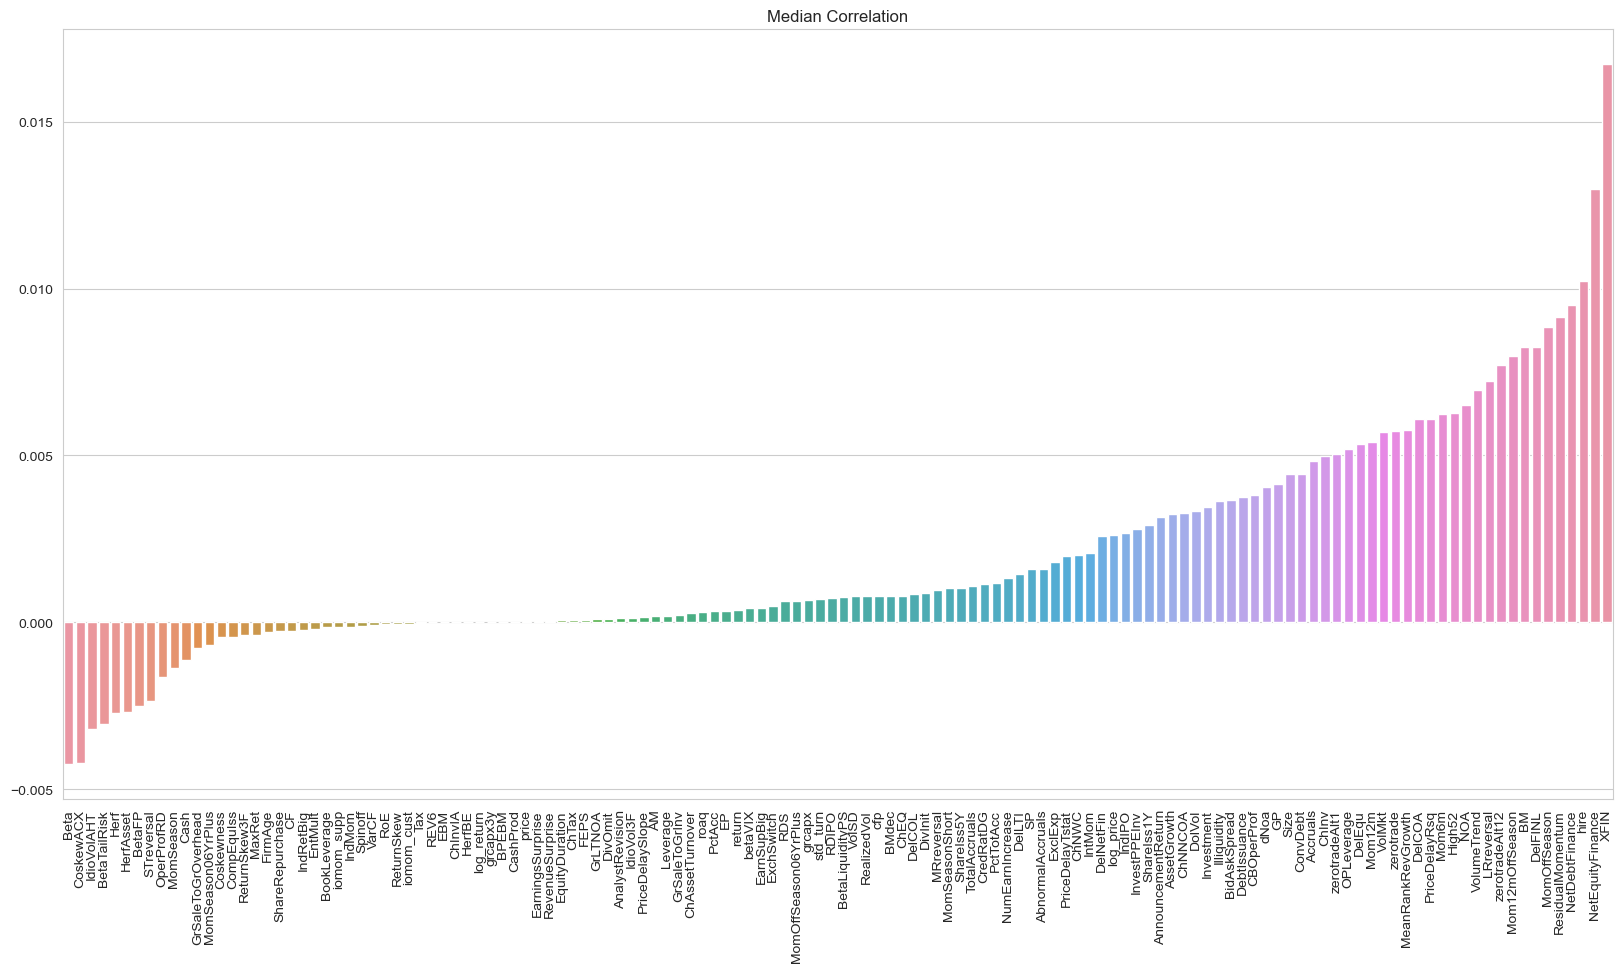

In [19]:
correlation.plot(plot_type= 'median')

### OLS

One basic idea is to compute the linear regression of our predictors in function of our label and to see the weights given to each predictor. As seen in class, using regularization can help achieve predictors selection. We then implement :

1) Simple OLS
2) Lasso OLS
3) Ridge OLS
4) Elastic Net OLS


### Random Forest

Using Random Forest can also be a good way to select predictors. We then train a Random Forest into our label using the whole Dataset and we look at the importance of each predictors.

In [68]:
test_data = data.sample(300000)
rf = RandomForest(data=data, target='return')

In [ ]:
rf.hyperparameter_tuning_with_crossvalidation(max_features=['sqrt', 'log2'], cv_splits=3)

In [70]:
rf.fit_predict_and_print_score()

With the following data:
- Data shape: (1745273, 134)
- Target: return
and the following hyperparameters:
- n_estimators: 50
- max_depth: 3
- max_features: sqrt
The R2 score is: -0.08844227682602512
The MSE is: 0.32079979634641564


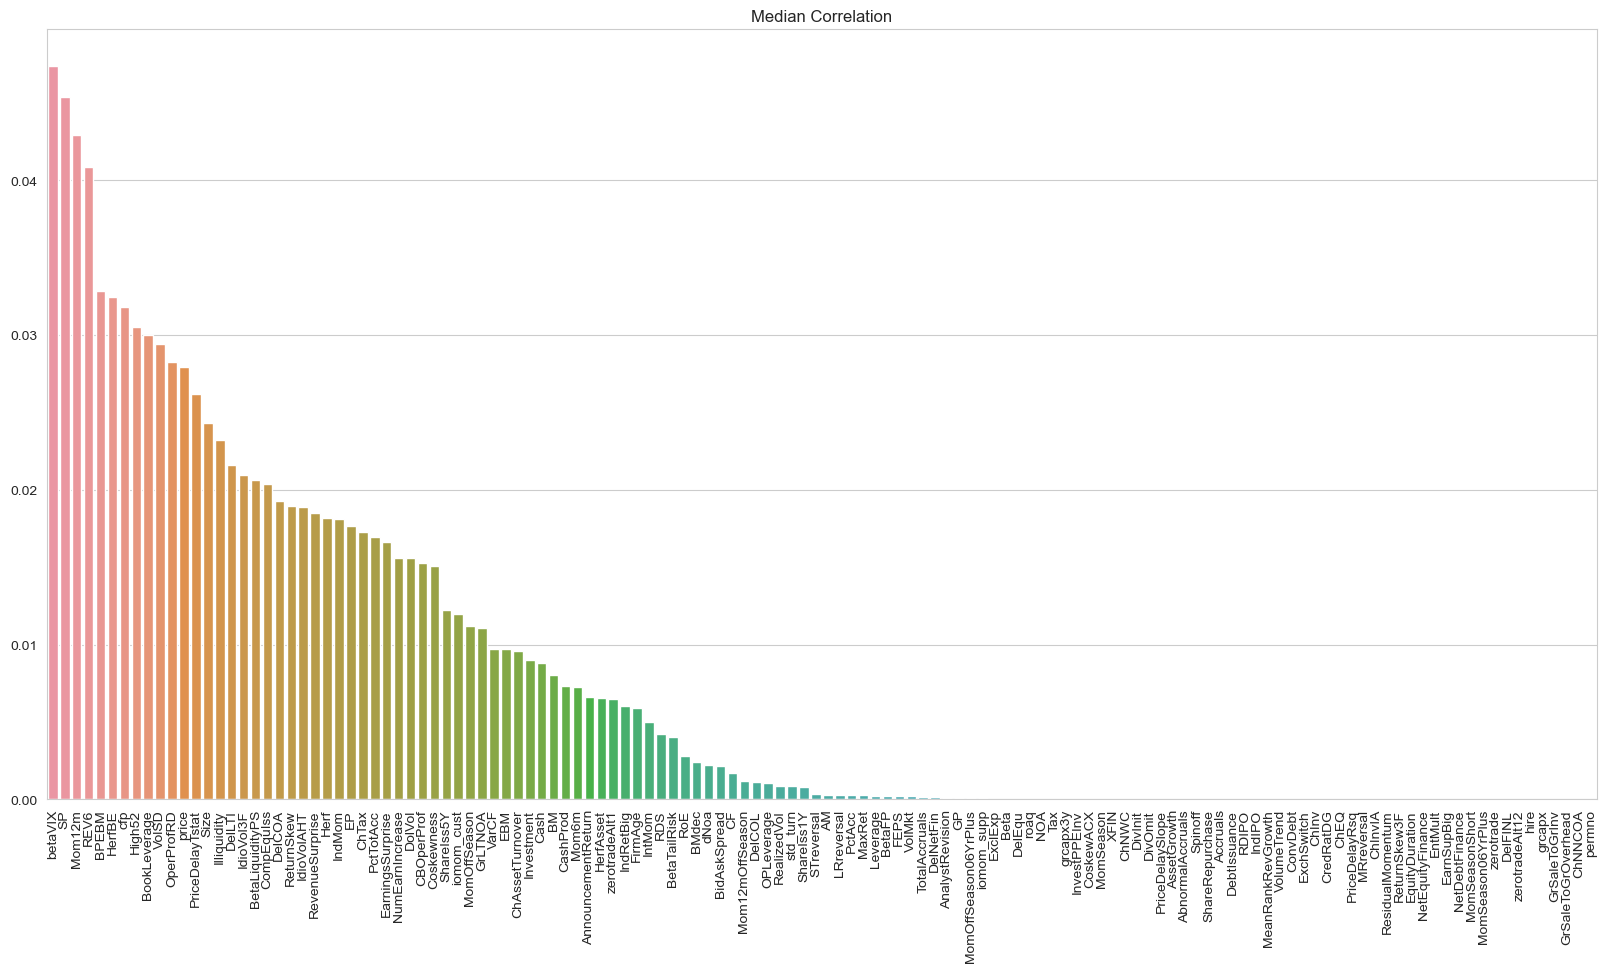

In [71]:
rf.plot_feature_importance()

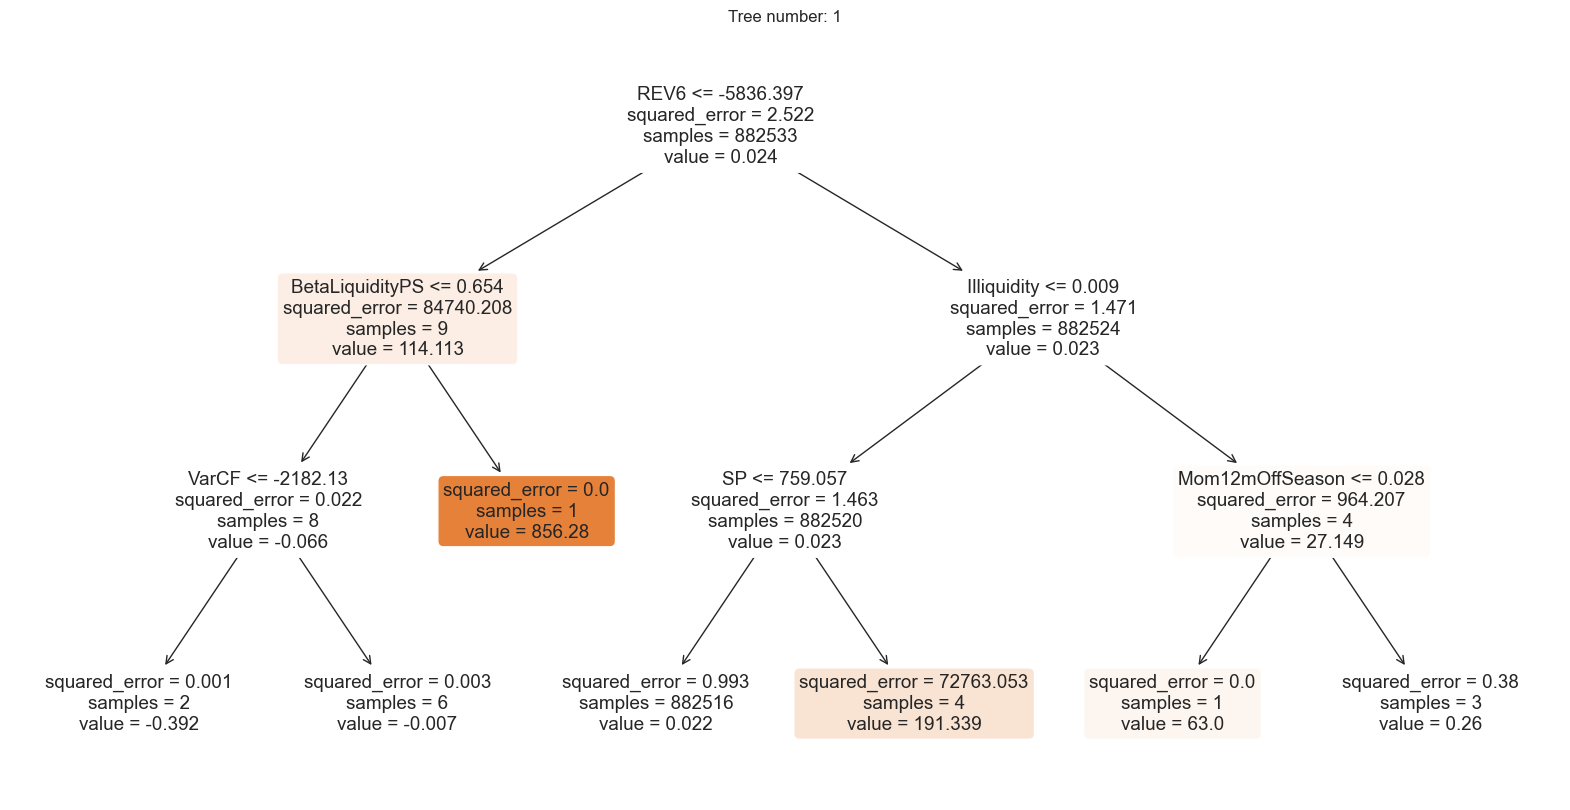

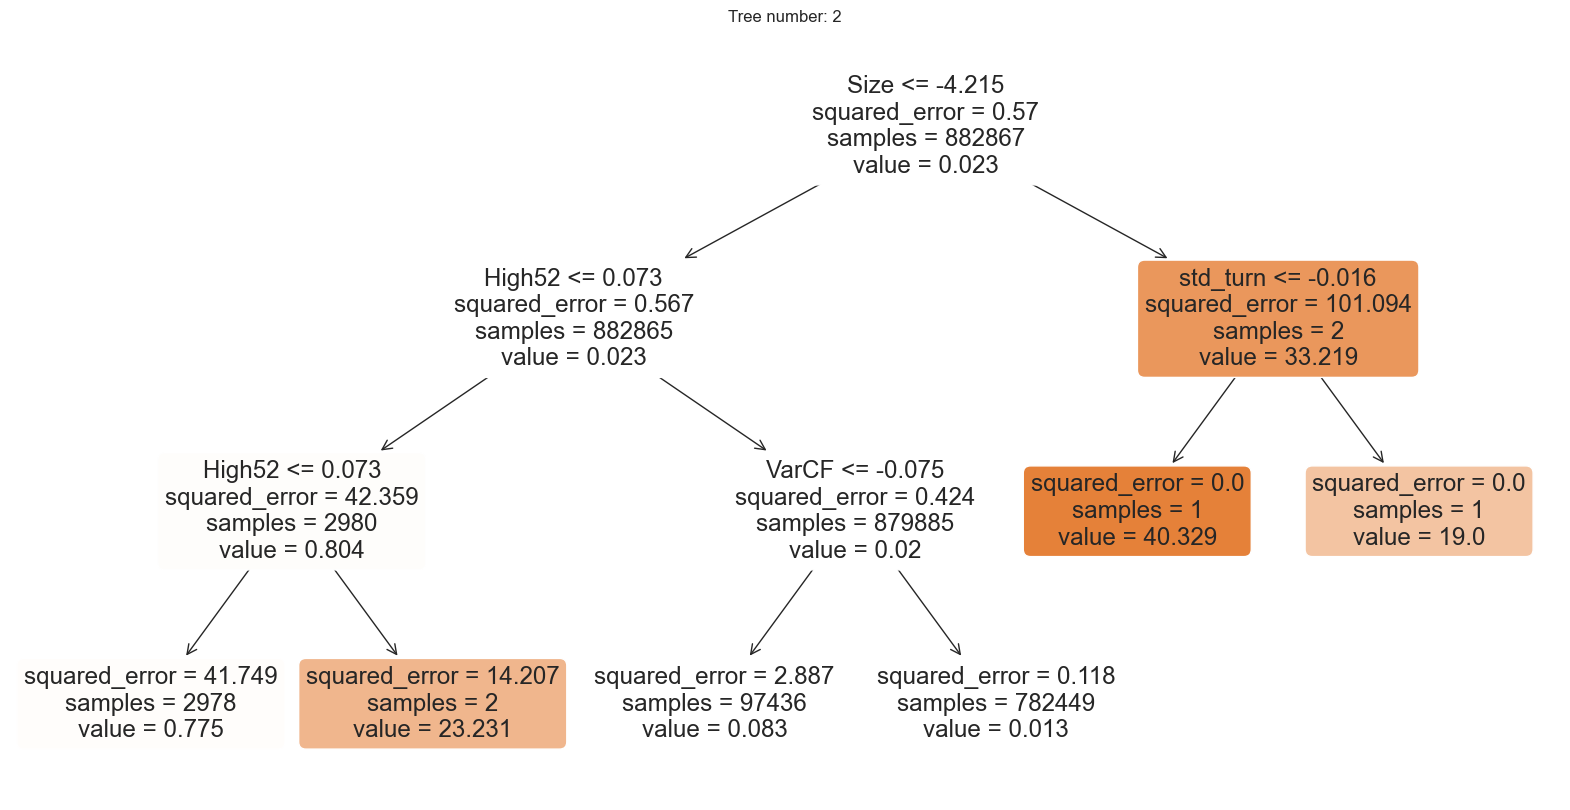

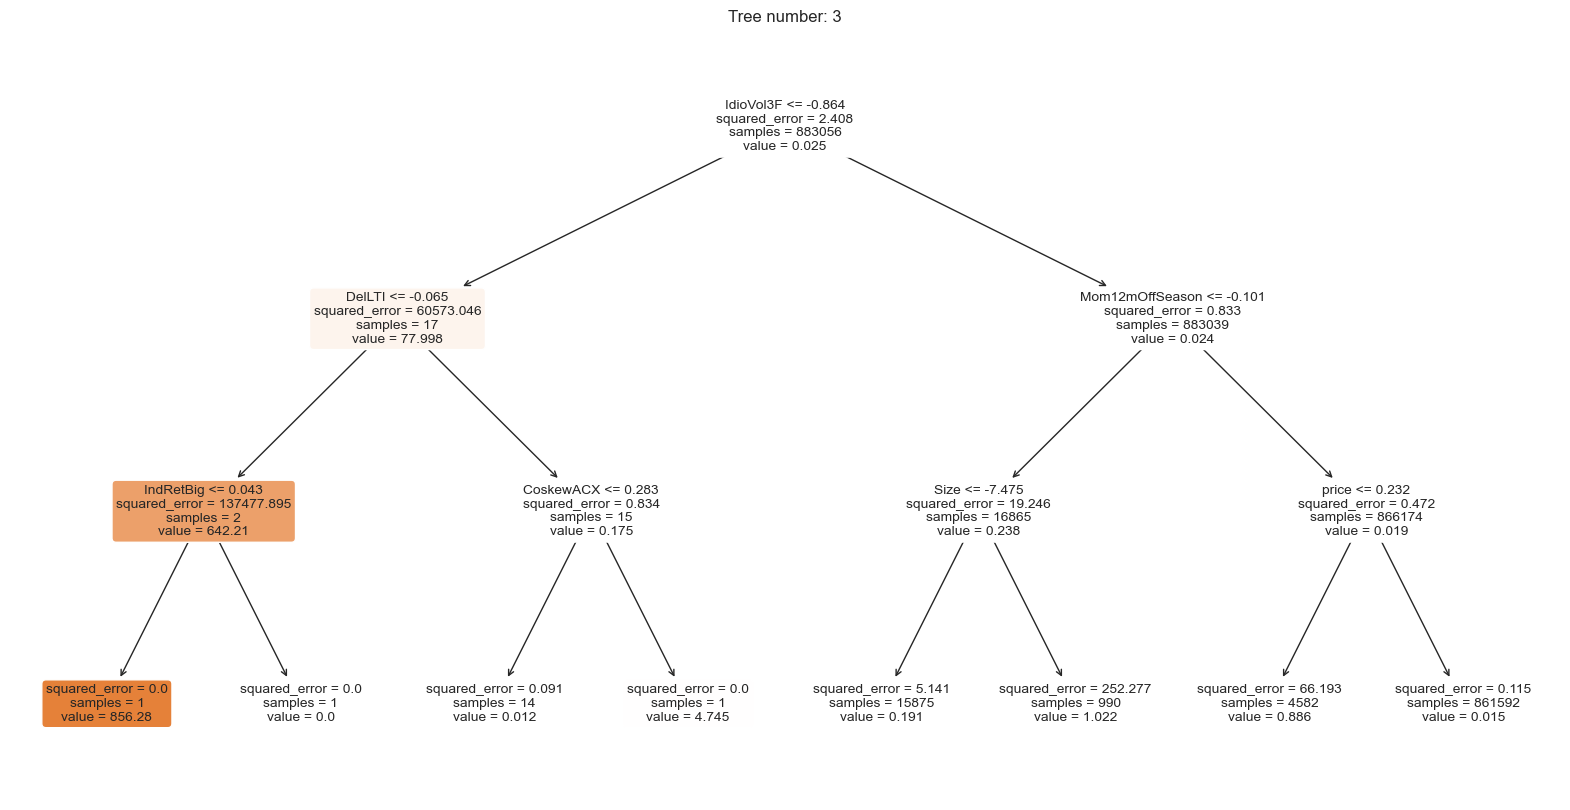

In [72]:
rf.plot_decision_tree()

## Results

We will test our models and compare them to see which one outperform the others.